# MLP

Use MLP of size 256, 128, 64 and relu activation. 

Use Splitter2.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-20 09:41:59.195356
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

ALPHABET_SIZE=4
K=4
VOCABULARY_SIZE = ALPHABET_SIZE**K 
from TrainValidSplit2 import Splitter2
EPOCHS=10
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    act='relu'
    dense1_layer = keras.layers.Dense(256, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(128, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation='sigmoid',dtype=dt)

    mlp = keras.models.Sequential()
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [10]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    data_partitions = splitter.get_train_valid_partitions(universe)
    for one_partition in data_partitions:
        train_genes,valid_genes = one_partition[0],one_partition[1]
        thresholds = splitter.choose_thresholds(train_genes)
        X_train,y_train = splitter.get_X_y(train_genes, thresholds)
        X_valid,y_valid = splitter.get_X_y(valid_genes, thresholds)

        fold += 1
        print('Fold',fold)
        print('Thresholds',thresholds)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


## Train and validate

In [11]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-20 09:57:33.402235
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-20 09:57:36.927509


In [12]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-20 09:57:36.940744
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 107,009
Trainable params: 107,009
Non-trainable params: 0
_________________________________________________________________
None


Cross valiation
2022-10-20 09:57:37.145870
Fold 1
Thresholds (-0.06339805672404636, -0.06339805672404636)
Train set ones/size 22203 / 43098
Valid set ones/size 6149 / 11253
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1347/1347 [==============================] - 6s 4ms/step - loss: 0.6078 - accuracy: 0.6883 - val_loss: 0.6032 - val_accuracy: 0.6878
Epoch 2/10
1347/1347 [==============================] - 5s 3ms/step - loss: 0.5584 - accuracy: 0.7191 - val_loss: 0.5834 - val_accuracy: 0.6998
Epoch 3/10
1347/1347 [==============================] - 5s 4ms/step - loss: 0.5374 - accuracy: 0.7324 - val_loss: 0.5803 - val_accuracy: 0.6969
Epoch 4/10
1347/1347 [==============================] - 5s 4ms/step - loss: 0.5127 - accuracy: 0.7496 - val_loss: 0.6072 - val_accuracy: 0.6915
Epoch 5/10
1347/1347 [==============================] - 6s 5ms/step - loss: 0.4868 - accuracy: 0.7673 - val_loss: 0.6302 - val_accuracy: 0.6708
Epoch 6/10
1347/1347 [==============================] - 7s 5ms/step 

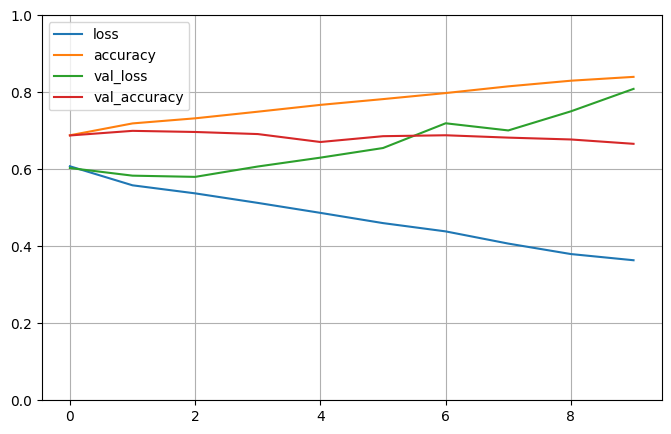

accuracy: 66.61%
Fold 2
Thresholds (-0.051316687318445194, -0.051316687318445194)
Train set ones/size 22392 / 43483
Valid set ones/size 5710 / 10868
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1359/1359 [==============================] - 5s 4ms/step - loss: 0.6157 - accuracy: 0.6879 - val_loss: 0.5968 - val_accuracy: 0.6948
Epoch 2/10
1359/1359 [==============================] - 9s 7ms/step - loss: 0.5623 - accuracy: 0.7128 - val_loss: 0.5991 - val_accuracy: 0.6951
Epoch 3/10
1359/1359 [==============================] - 13s 10ms/step - loss: 0.5421 - accuracy: 0.7278 - val_loss: 0.6297 - val_accuracy: 0.6796
Epoch 4/10
1359/1359 [==============================] - 12s 8ms/step - loss: 0.5250 - accuracy: 0.7378 - val_loss: 0.6100 - val_accuracy: 0.6895
Epoch 5/10
1359/1359 [==============================] - 7s 5ms/step - loss: 0.4971 - accuracy: 0.7583 - val_loss: 0.6312 - val_accuracy: 0.6800
Epoch 6/10
1359/1359 [==============================] - 12s 9ms/step - loss: 0.4690 - acc

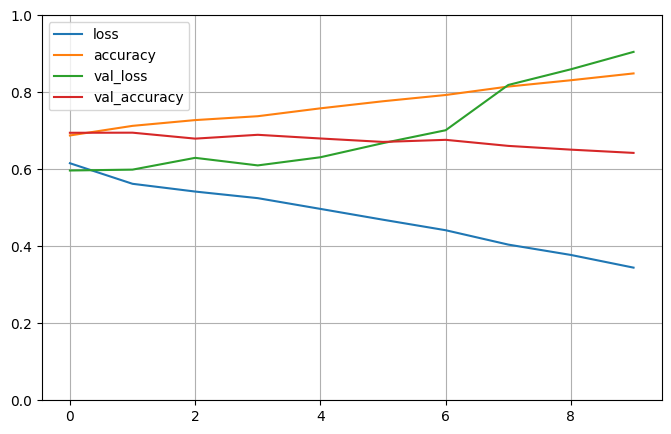

accuracy: 64.25%
Fold 3
Thresholds (-0.051095313668638336, -0.051095313668638336)
Train set ones/size 22477 / 43451
Valid set ones/size 5625 / 10900
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1358/1358 [==============================] - 14s 9ms/step - loss: 0.6109 - accuracy: 0.6890 - val_loss: 0.6150 - val_accuracy: 0.6773
Epoch 2/10
1358/1358 [==============================] - 11s 8ms/step - loss: 0.5608 - accuracy: 0.7137 - val_loss: 0.5787 - val_accuracy: 0.7078
Epoch 3/10
1358/1358 [==============================] - 11s 8ms/step - loss: 0.5393 - accuracy: 0.7297 - val_loss: 0.5938 - val_accuracy: 0.6971
Epoch 4/10
1358/1358 [==============================] - 11s 8ms/step - loss: 0.5182 - accuracy: 0.7475 - val_loss: 0.6296 - val_accuracy: 0.6639
Epoch 5/10
1358/1358 [==============================] - 18s 13ms/step - loss: 0.4837 - accuracy: 0.7699 - val_loss: 0.6516 - val_accuracy: 0.6753
Epoch 6/10
1358/1358 [==============================] - 17s 13ms/step - loss: 0.4580 -

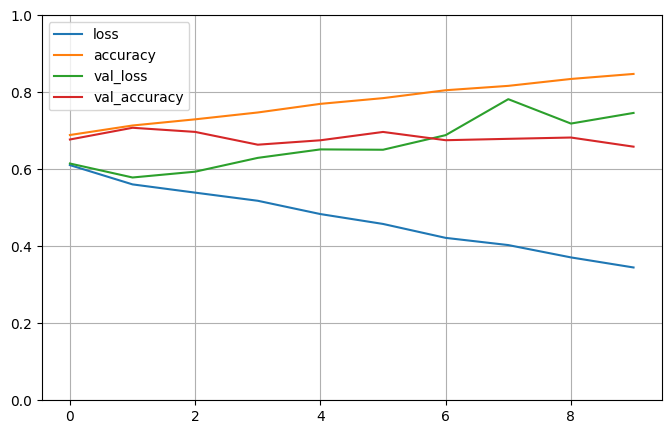

accuracy: 65.87%
Fold 4
Thresholds (-0.047797078149324, -0.047797078149324)
Train set ones/size 22724 / 43564
Valid set ones/size 5320 / 10787
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1362/1362 [==============================] - 13s 9ms/step - loss: 0.6109 - accuracy: 0.6884 - val_loss: 0.5935 - val_accuracy: 0.6812
Epoch 2/10
1362/1362 [==============================] - 10s 8ms/step - loss: 0.5639 - accuracy: 0.7150 - val_loss: 0.5974 - val_accuracy: 0.6873
Epoch 3/10
1362/1362 [==============================] - 11s 8ms/step - loss: 0.5417 - accuracy: 0.7293 - val_loss: 0.5929 - val_accuracy: 0.6979
Epoch 4/10
1362/1362 [==============================] - 11s 8ms/step - loss: 0.5240 - accuracy: 0.7403 - val_loss: 0.6213 - val_accuracy: 0.6959
Epoch 5/10
1362/1362 [==============================] - 14s 10ms/step - loss: 0.4977 - accuracy: 0.7590 - val_loss: 0.6495 - val_accuracy: 0.6580
Epoch 6/10
1362/1362 [==============================] - 11s 8ms/step - loss: 0.4707 - accura

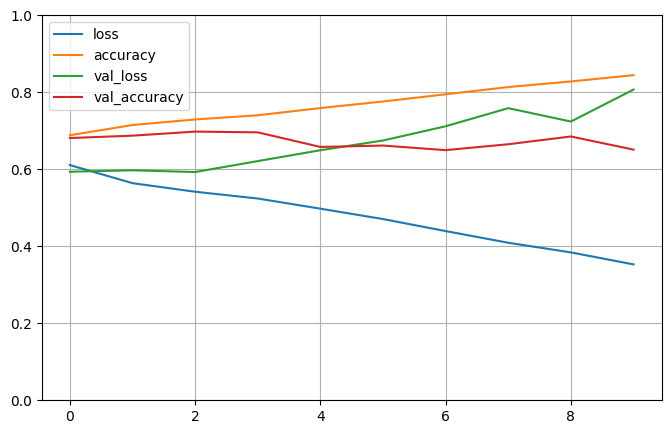

accuracy: 65.11%
Fold 5
Thresholds (-0.044162605550458714, -0.044162605550458714)
Train set ones/size 22732 / 43835
Valid set ones/size 5297 / 10516
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1370/1370 [==============================] - 12s 8ms/step - loss: 0.6133 - accuracy: 0.6871 - val_loss: 0.5670 - val_accuracy: 0.7178
Epoch 2/10
1370/1370 [==============================] - 10s 7ms/step - loss: 0.5643 - accuracy: 0.7117 - val_loss: 0.5764 - val_accuracy: 0.7098
Epoch 3/10
1370/1370 [==============================] - 10s 7ms/step - loss: 0.5431 - accuracy: 0.7274 - val_loss: 0.5670 - val_accuracy: 0.7158
Epoch 4/10
1370/1370 [==============================] - 9s 6ms/step - loss: 0.5253 - accuracy: 0.7395 - val_loss: 0.6004 - val_accuracy: 0.6899
Epoch 5/10
1370/1370 [==============================] - 9s 7ms/step - loss: 0.4978 - accuracy: 0.7574 - val_loss: 0.6185 - val_accuracy: 0.7076
Epoch 6/10
1370/1370 [==============================] - 9s 6ms/step - loss: 0.4676 - accu

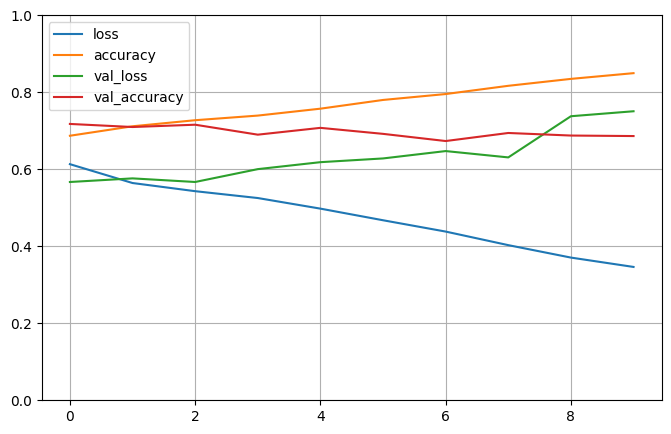

accuracy: 68.63%

Validation core mean 66.09% (+/- 1.49%)
2022-10-20 10:06:25.345843


In [13]:
# Train
print ("Cross valiation")
print(datetime.now())
do_cross_validation(splitter,EPOCHS)
print(datetime.now())